# NDVI Visualization (Brahmanbaria, 2016-11-13)
Visualize the clipped NDVI raster with a categorical colormap aligned to vegetation condition classes.

Raster: `map/2016/brahmanbaria_ndvi_20161113.tif`


In [ ]:
import sys
from pathlib import Path

# notebooks/ → project root
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import src.geo_env   # MUST come immediately after path fix

In [2]:
import rasterio
from rasterio.crs import CRS
print(CRS.from_epsg(4326))

EPSG:4326


In [3]:
from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.enums import Resampling
import os


project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
ndvi_path = project_root / "map" / "2016" / "brahmanbaria_ndvi_20161113.tif"
assert ndvi_path.exists(), f"NDVI raster not found: {ndvi_path}"

In [4]:
from rasterio.warp import transform_bounds

scale_factor = 4
with rasterio.open(ndvi_path) as src:
    out_height = max(1, src.height // scale_factor)
    out_width = max(1, src.width // scale_factor)
    ndvi = src.read(
        1,
        out_shape=(out_height, out_width),
        resampling=Resampling.average,
    )
    ndvi = np.ma.masked_invalid(ndvi)
    # reproject bounds to WGS84 for display axes
    lon_min, lat_min, lon_max, lat_max = transform_bounds(src.crs, "EPSG:4326", *src.bounds)
    extent = [lon_min, lon_max, lat_min, lat_max]
    print(f"CRS: {src.crs}, full shape: {src.height}x{src.width}, downsampled: {ndvi.shape}, "
        f"min: {ndvi.min()}, max: {ndvi.max()}")

bounds = [-0.5, 0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.5]
hex_colors = ["#08306B", "#D9D9D9", "#FEE391", "#A6D96A", "#66BD63", "#1A9850", "#006837"]
labels = [
    "< 0 (Water)", #"< 0 (Water/Snow/Clouds)",
    "0–0.1 (Bare/Urban)",
    "0.1–0.2 (Very Sparse)",
    "0.2–0.4 (Sparse–Moderate)",
    "0.4–0.6 (Moderate)",
    "0.6–0.8 (Dense)",
    "> 0.8 (Very Dense)",
]
cmap = ListedColormap(hex_colors)
norm = BoundaryNorm(bounds, cmap.N)
ticks = [(-0.5 + 0)/2, (0 + 0.1)/2, (0.1 + 0.2)/2, (0.2 + 0.4)/2,
        (0.4 + 0.6)/2, (0.6 + 0.8)/2, (0.8 + 1.5)/2]

CRS: EPSG:32646, full shape: 6873x6261, downsampled: (1718, 1565), min: -0.29273703694343567, max: 0.659973680973053


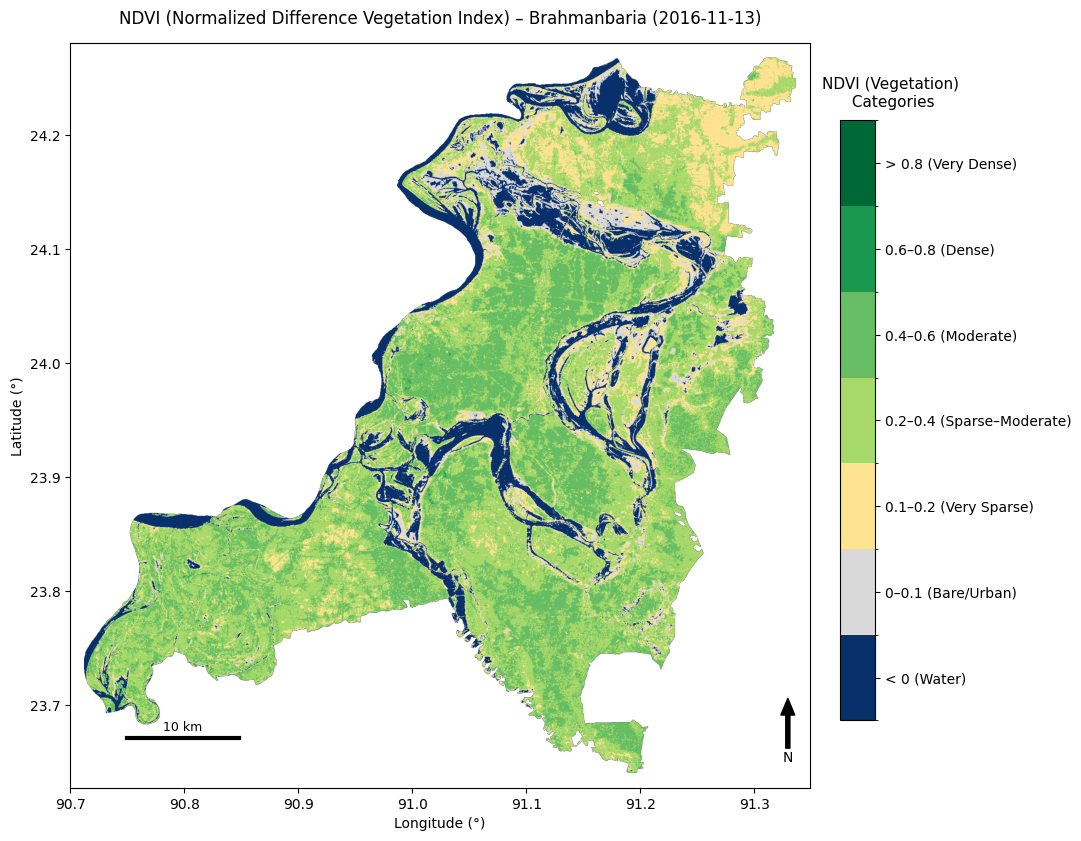

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
im = ax.imshow(
    ndvi,
    cmap=cmap,
    norm=norm,
    extent=extent,
    origin="upper"
)

# 🔹 TRUE padding between map and frame (imshow-safe)
pad_frac = 0.02  # 2% padding inside frame
dx = (extent[1] - extent[0]) * pad_frac
dy = (extent[3] - extent[2]) * pad_frac

ax.set_xlim(extent[0] - dx, extent[1] + dx)
ax.set_ylim(extent[2] - dy, extent[3] + dy)

ax.set_title("NDVI (Normalized Difference Vegetation Index) – Brahmanbaria (2016-11-13)", pad=14)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")

fig.subplots_adjust(left=0.08, right=0.82, top=0.93, bottom=0.08)

# 🔹 Vertical colorbar with title ON TOP
cax = fig.add_axes([0.85, 0.2, 0.035, 0.6])
cbar = fig.colorbar(
    im,
    cax=cax,
    boundaries=bounds,
    ticks=ticks
)
cbar.ax.set_yticklabels(labels)
cbar.ax.set_title("NDVI (Vegetation)\n Categories", fontsize=11, pad=10)
cbar.ax.title.set_position((1.45, 1.02))  # (x, y) → move right & slightly up


# North arrow
ax.annotate(
    "N",
    xy=(0.97, 0.12),
    xytext=(0.97, 0.04),
    xycoords="axes fraction",
    ha="center",
    va="center",
    arrowprops=dict(facecolor="black", width=3, headwidth=10),
)

# Scale bar (~10 km)
scale_len_km = 10
mid_lat = (lat_min + lat_max) / 2
deg_per_km_lon = 1 / (111.32 * np.cos(np.deg2rad(mid_lat)))
bar_len_lon = scale_len_km * deg_per_km_lon

x0 = extent[0] + 0.06 * (extent[1] - extent[0])
y0 = extent[2] + 0.05 * (extent[3] - extent[2])

ax.plot([x0, x0 + bar_len_lon], [y0, y0], color="k", lw=3)
ax.text(
    x0 + bar_len_lon / 2,
    y0 + (extent[3] - extent[2]) * 0.006,
    f"{scale_len_km} km",
    ha="center",
    va="bottom",
    fontsize=9,
)

fig.savefig(
    r"F:\brahmanbariavegetation\outputs\ndvi_2016_11_13_brahmanbaria.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()